# Track 2D slices using 3D StarDist model

In [21]:
%load_ext autoreload
%autoreload 2

import h5py
from scipy import ndimage
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual, fixed
import ipywidgets as widgets
from IPython.display import display
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
lbl_cmap = random_label_cmap()
import h5py
from glob import glob
import numpy as np
from csbdeep.utils import Path, normalize
from tqdm import tqdm
from trackers import *
import pickle
import sys
import stardistwrapper as sdw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Prepare training data

In [2]:
path = 'data/GT/'
t_f = h5py.File(path+'GT_TrackID.h5','r+') # Track file
track = t_f['image'][:]
t_f.close()

In [43]:
max_t, max_z, *_ = track.shape
kernel = np.ones((1, 3, 3), np.uint8) # Erode Z,Y,X

_X = np.zeros(track.shape)
_Y = np.zeros(track.shape)
for t in range(max_t):
    _f = track[t]
    
    # Erode X,Y axis
    for g in np.unique(_f):
        _mask = mask(_f, g)
        _mask2 = ndimage.binary_erosion(_mask, structure=kernel)
        _X[t] = _X[t] + _mask2
        _Y[t] = _Y[t] + _mask2*g
        
_X = _X.transpose((1,0,2,3))
_Y = _Y.transpose((1,0,2,3))
for i in range(max_z):
    file='time_segmentation/train_m1/data_TYX_Z%s.h5' %i
    _f = h5py.File(path+file, 'w') # Track file
    _f.create_dataset('X', data=_X[i])
    _f.create_dataset('Y', data=_Y[i])
    _f.close()

In [44]:
def load_fatepredict_temporal_data(dataset, n_channel=1):
    _path = path+'/time_segmentation/%s/data_*.h5' % dataset
    files = sorted(glob(_path))
    _X = []
    _Y = []
    
    for f in files:
        f = h5py.File(f, 'r')
        _X.append(f['X'][:])
        _Y.append(f['Y'][:].astype(int))
        f.close()
        
    # Normalize
    _X = [normalize(x, 1, 99.8) for x in tqdm(_X)]
    
    # Split the dataset
    rng = np.random.RandomState(42)
    ind = rng.permutation(len(_X))
    
    n_val = max(1, int(round(0.15 * len(ind))))
    ind_train, ind_val = ind[:-n_val], ind[-n_val:]
    
    _X_val, _Y_val = [_X[i] for i in ind_val], [_Y[i] for i in ind_val]
    _X_trn, _Y_trn = [_X[i] for i in ind_train], [_Y[i] for i in ind_train]

    print('number of images: %3d' % len(_X))
    print('- training:       %3d' % len(_X_trn))
    print('- validation:     %3d' % len(_X_val))
    print(f"X[0].shape={_X[0].shape}")

    return _X, _Y, _X_trn, _Y_trn, _X_val, _Y_val, n_channel

In [45]:
X, Y, X_trn, Y_trn, X_val, Y_val, n_channel = \
    load_fatepredict_temporal_data('train_m1')

100%|██████████| 43/43 [00:00<00:00, 108.28it/s]

number of images:  43
- training:        37
- validation:       6
X[0].shape=(11, 200, 201)


## Visualize data

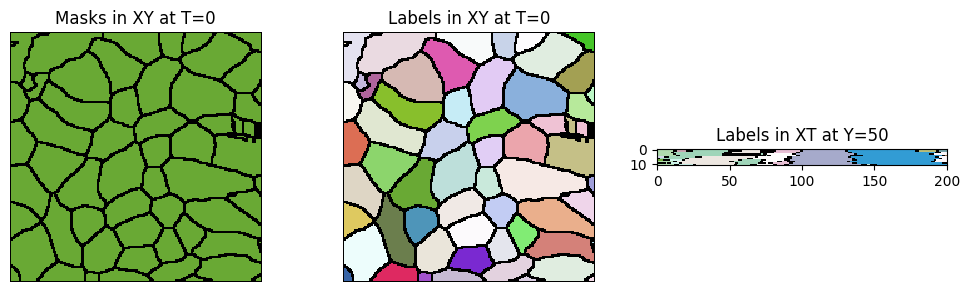

In [46]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(X[0][0], cmap=lbl_cmap)
plt.axis('off')
plt.title('Masks in XY at T=0')

fig.add_subplot(rows, columns, 2)
plt.imshow(Y[0][0], cmap=lbl_cmap)
plt.axis('off')
plt.title('Labels in XY at T=0')

fig.add_subplot(rows, columns, 3)
plt.imshow(Y[0].transpose((1, 0, 2))[50], cmap=lbl_cmap)
plt.title('Labels in XT at Y=50')

plt.tight_layout()
plt.savefig('exp4.1_TYX_data.png')
plt.show()

## Model1

In [ ]:
import napari

filter = (Y[0]==39) | (Y[0]==34) | (Y[0]==29) | (Y[0]==25)
viewer = napari.Viewer()
viewer.add_labels(Y[0]*filter, name='Labels')

### Configure + train

In [20]:
model_name="fatepredict_temporal_model1"
model = sdw.configure(Y, n_channel, model_name=model_name)

empirical anisotropy of labeled objects = (3.857142857142857, 1.173913043478261, 1.0)
div_by=(4, 8, 8)
n_dim: 3
axes: ZYXC
n_channel_in: 1
n_channel_out: 97
train_checkpoint: weights_best.h5
train_checkpoint_last: weights_last.h5
train_checkpoint_epoch: weights_now.h5
n_rays: 96
grid: (1, 2, 2)
anisotropy: (3.857142857142857, 1.173913043478261, 1.0)
backbone: unet
rays_json: {'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (3.857142857142857, 1.173913043478261, 1.0)}}
n_classes: None
unet_n_depth: 2
unet_kernel_size: (3, 3, 3)
unet_n_filter_base: 32
unet_n_conv_per_depth: 2
unet_pool: (2, 2, 2)
unet_activation: relu
unet_last_activation: relu
unet_batch_norm: False
unet_dropout: 0.0
unet_prefix: 
net_conv_after_unet: 128
net_input_shape: (None, None, None, 1)
net_mask_shape: (None, None, None, 1)
train_patch_size: [8, 32, 32]
train_background_reg: 0.0001
train_foreground_only: 0.9
train_sample_cache: True
train_dist_loss: mae
train_loss_weights: (1, 0.2)
train_class_weig

In [21]:
model_hist = model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=sdw.augmenter, epochs=1000)

Epoch 1/1000
100/100 [==============================] - 8s 37ms/step - loss: 1.7999 - prob_loss: 0.6248 - dist_loss: 5.8752 - prob_kld: 0.1837 - dist_relevant_mae: 5.8751 - dist_relevant_mse: 61.7608 - dist_dist_iou_metric: 0.0846 - val_loss: 1.3322 - val_prob_loss: 0.6166 - val_dist_loss: 3.5784 - val_prob_kld: 0.1838 - val_dist_relevant_mae: 3.5781 - val_dist_relevant_mse: 28.4293 - val_dist_dist_iou_metric: 0.2368 - lr: 3.0000e-04
Epoch 2/1000
100/100 [==============================] - 3s 26ms/step - loss: 1.3587 - prob_loss: 0.6220 - dist_loss: 3.6836 - prob_kld: 0.1837 - dist_relevant_mae: 3.6833 - dist_relevant_mse: 29.3403 - dist_dist_iou_metric: 0.2704 - val_loss: 1.2587 - val_prob_loss: 0.6339 - val_dist_loss: 3.1239 - val_prob_kld: 0.2011 - val_dist_relevant_mae: 3.1236 - val_dist_relevant_mse: 23.8503 - val_dist_dist_iou_metric: 0.2747 - lr: 3.0000e-04
Epoch 3/1000
100/100 [==============================] - 3s 26ms/step - loss: 1.2494 - prob_loss: 0.6153 - dist_loss: 3.1701 

### Training graph

In [ ]:
import pickle
pickle.dump(model_hist, open('model1_temporal_hist.pkl', 'wb'))

In [ ]:
plt.figure()
plt.plot(model_hist.history['loss'], label='Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')

plt.title('Training of Temporal Segmentation Model2')
plt.legend(loc = 'upper right')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.savefig('exp4.1_training.png')
plt.show()

### Predict + Visualize output

In [12]:
model_name="fatepredict_temporal_model1"
model = sdw.load_stardist_model(model_name=model_name)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.734776, nms_thresh=0.3.
Load pretrained stardist model 'fatepredict_temporal_model1' from folder 'stardist_models'


In [ ]:
model.optimize_thresholds(X_val, Y_val)

2023-12-04 08:04:56.932824: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
NMS threshold = 0.5:  75%|███████▌  | 15/20 [15:45<05:15, 63.02s/it, 0.735 -> 0.204]  


Using optimized values: prob_thresh=0.734776, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.7347755901092565, 'nms': 0.3}

In [13]:
Y_val_pred1_all = [model.predict_instances(x, show_tile_progress=False)
              for x in tqdm(X_val)]

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1/6 [00:12<01:04, 12.99s/it]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2/6 [00:20<00:39,  9.76s/it]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3/6 [00:29<00:28,  9.63s/it]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4/6 [00:34<00:15,  7.77s/it]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5/6 [00:36<00:05,  5.51s/it]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 6/6 [00:37<00:00,  6.20s/it]


In [11]:
pickle.dump(Y_val_pred1_all, open('exp4.1_Y_val_pred1_all.pkl', 'wb'))

In [15]:
Y_val_pred1_all = pickle.load(open('exp4.1_Y_val_pred1_all.pkl', 'rb'))
Y_val_pred1 = [x[0][0] for x in Y_val_pred1_all]

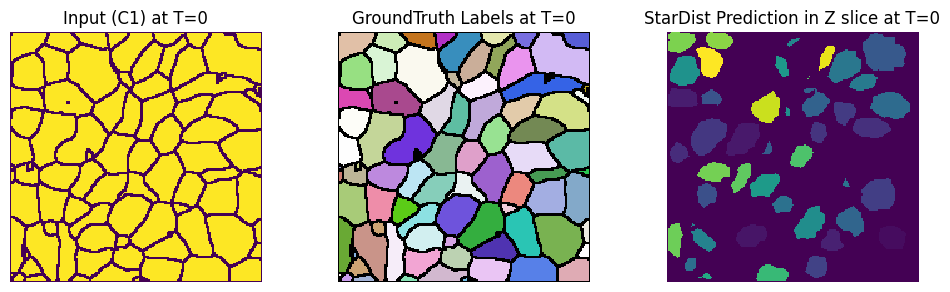

In [54]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(X_val[4][0])
plt.axis('off')
plt.title('Input (C1) at T=0')

fig.add_subplot(rows, columns, 2)
plt.imshow(Y_val[4][0], cmap=lbl_cmap)
plt.axis('off')
plt.title('GroundTruth Labels at T=0')

fig.add_subplot(rows, columns, 3)
plt.imshow(Y_val_pred1[4][0])
plt.axis('off')
plt.title('StarDist Prediction in Z slice at T=0')

plt.tight_layout()
plt.savefig('4.1_model1_predicted_track.png')
plt.show()

In [196]:
# Visualize in napari

### Measure performance

In [17]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats1 = [matching_dataset(Y_val, Y_val_pred1, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:01<00:00,  5.28it/s]


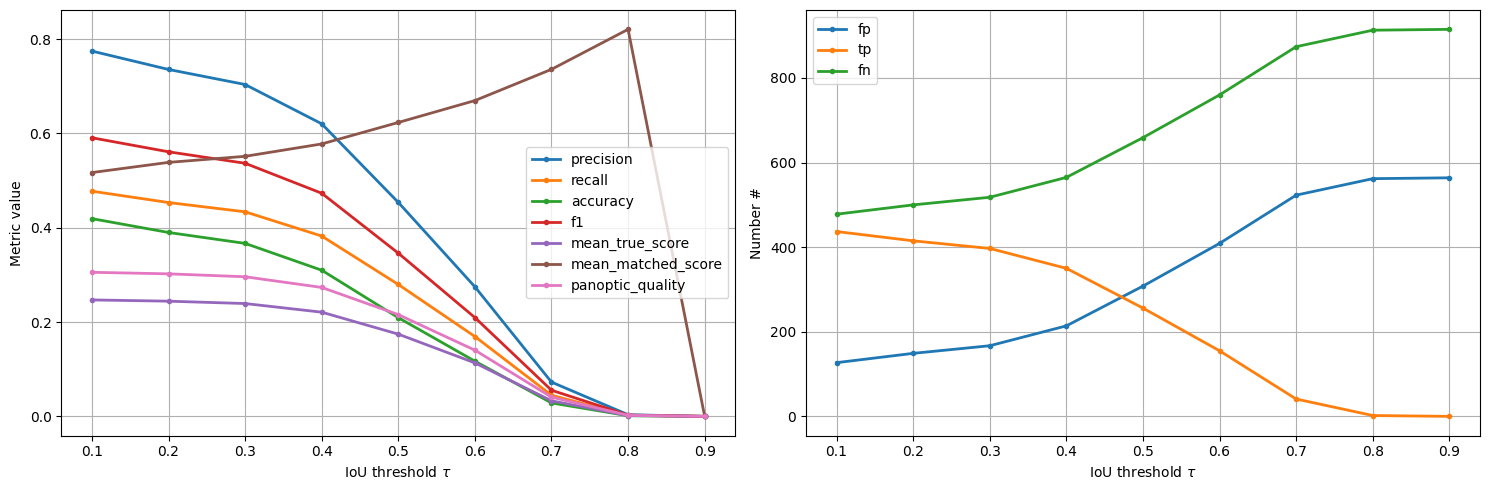

In [38]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats1], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats1], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.savefig('4.1_pr_stardist_2d_track.png')

In [19]:
print('%.3f & %.3f & %.3f & %.3f & %.2f & %.2f\\\\' % (stats1[taus.index(0.5)].f1, stats1[taus.index(0.5)].accuracy, stats1[taus.index(0.7)].f1, stats1[taus.index(0.7)].accuracy, stats1[taus.index(0.9)].f1, stats1[taus.index(0.9)].accuracy))

0.346 & 0.209 & 0.055 & 0.029 & 0.00 & 0.00\\


#### HOTA

0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
{'HOTA': array([0.61684611, 0.59913409, 0.58755296, 0.57410898, 0.55693194,
       0.54071627, 0.52758267, 0.50975898, 0.4810061 , 0.45549955,
       0.41719721, 0.37634302, 0.33206164, 0.29102768, 0.23850984,
       0.1762128 , 0.08888099, 0.0195467 , 0.        ]), 'DetA': array([0.56127703, 0.54536188, 0.53286148, 0.51751752, 0.49802372,
       0.48336595, 0.47041707, 0.45210728, 0.42884072, 0.40761374,
       0.37070524, 0.32982456, 0.28583545, 0.24364233, 0.19747235,
       0.13643178, 0.05792045, 0.00530504, 0.        ]), 'AssA': array([0.67791678, 0.6582082 , 0.64785783, 0.63688883, 0.62280807,
       0.60487109, 0.5916951 , 0.57476228, 0.53951703, 0.5090109 ,
       0.46951995, 0.42942245, 0.38576366, 0.34762888, 0.28807548,
       0.22759325, 0.13639106, 0.07202081, 0.        ]), 'DetRe': array([0.61167228, 0.60044893, 0.59147026, 0.58024691, 0.56565657,
       0.55443322, 0.54433221, 0.52974186, 0.51066218, 0.49270483,
       0.460

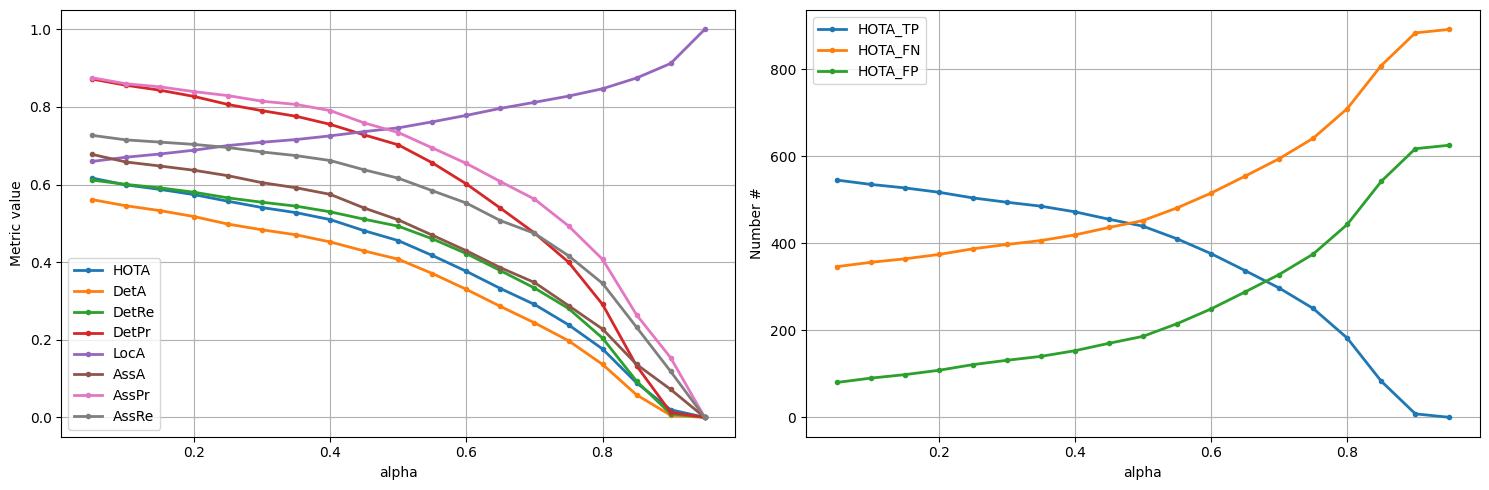

In [35]:
from trackeval_fatepredict import FatePredictDataset
track_eval = FatePredictDataset(Y_val[0], Y_val_pred1[0])

from trackeval.metrics.hota import HOTA
hota = HOTA()
hota_metrics = hota.eval_sequence(track_eval.data)

# Print metrics
print(hota_metrics)

# Visualize
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('HOTA', 'DetA', 'DetRe', 'DetPr', 'LocA', 'AssA', 'AssPr', 'AssRe'):
    ax1.plot(hota.array_labels, [s for s in hota_metrics[m]], '.-', lw=2, label=m)
ax1.set_xlabel(r'alpha')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('HOTA_TP', 'HOTA_FN', 'HOTA_FP'):
    ax2.plot(hota.array_labels, [s for s in hota_metrics[m]], '.-', lw=2, label=m)
ax2.set_xlabel(r'alpha')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.savefig('4.1_hota_metrics_stardist_2d_track.png')

In [61]:
print('%.3f & %.3f & %.3f & %.3f & %.3f & %.3f & %.3f & %.3f\\\\' % (hota_metrics['AssA'][9], hota_metrics['AssA'][17], hota_metrics['DetA'][9], hota_metrics['DetA'][17],hota_metrics['LocA'][9], hota_metrics['LocA'][17], hota_metrics['HOTA'][9], hota_metrics['HOTA'][17]))

0.509 & 0.072 & 0.408 & 0.005 & 0.746 & 0.912 & 0.455 & 0.020\\


## Model2

### Configure + train

In [63]:
model_name3="fatepredict_temporal_model3"
model3 = sdw.configure(Y, n_channel, model_name=model_name3, n_rays=196, unet_kernel_size=(4,4,4), unet_n_conv_per_depth=5, unet_n_depth=3)

empirical anisotropy of labeled objects = (3.857142857142857, 1.173913043478261, 1.0)
If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
div_by=(8, 16, 16)
n_dim: 3
axes: ZYXC
n_channel_in: 1
n_channel_out: 197
train_checkpoint: weights_best.h5
train_checkpoint_last: weights_last.h5
train_checkpoint_epoch: weights_now.h5
n_rays: 196
grid: (1, 2, 2)
anisotropy: (3.857142857142857, 1.173913043478261, 1.0)
backbone: unet
rays_json: {'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 196, 'anisotropy': (3.857142857142857, 1.173913043478261, 1.0)}}
n_classes: None
unet_n_depth: 3
unet_kernel_size: (4, 4, 4)
unet_n_filter_base: 32
unet_n_conv_per_depth: 5
unet_pool: (2, 2, 2)
unet_activation: relu
unet_last_activation: relu
unet_batch_norm: False
unet_dropout: 0.0
unet_prefix: 
net_conv_after_unet: 128
net_input_shape: (None, None, None, 1)
net_mask_shape: (None, None, None, 1)
train_patch_size: [8, 32, 32]
train_background_reg: 0.0001
train_foreg

base_model.py (149): output path for model already exists, files may be overwritten: /home/jupyter/fatepredict/experiments/stardist_models/fatepredict_temporal_model3


Using default values: prob_thresh=0.5, nms_thresh=0.4.
median object size:      [ 7. 23. 27.]
network field of view :  [27 46 46]


In [ ]:
model_hist3 = model3.train(X_trn, Y_trn, validation_data=(X_val, Y_val), augmenter=sdw.augmenter, epochs=2000)

Epoch 1/2000
Cause: Unable to locate the source code of <function _gcd_import at 0x7f341ab67400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f341ab67400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f341ab67400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-12-06 20:09:00.347209: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f323c19c3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 20:09:00.347248: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-12-06 20:09:00.355112: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701893340.470764   89877 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 25s 92ms/step - loss: 1.7068 - prob_loss: 0.6343 - dist_loss: 5.3623 - prob_kld: 0.1932 - dist_relevant_mae: 5.3621 - dist_relevant_mse: 54.3124 - dist_dist_iou_metric: 0.1285 - val_loss: 1.2854 - val_prob_loss: 0.6133 - val_dist_loss: 3.3607 - val_prob_kld: 0.1805 - val_dist_relevant_mae: 3.3603 - val_dist_relevant_mse: 22.8229 - val_dist_dist_iou_metric: 0.3169 - lr: 3.0000e-04
Epoch 2/2000
100/100 [==============================] - 7s 74ms/step - loss: 1.2954 - prob_loss: 0.6127 - dist_loss: 3.4138 - prob_kld: 0.1744 - dist_relevant_mae: 3.4134 - dist_relevant_mse: 25.2107 - dist_dist_iou_metric: 0.3127 - val_loss: 1.2331 - val_prob_loss: 0.6143 - val_dist_loss: 3.0937 - val_prob_kld: 0.1816 - val_dist_relevant_mae: 3.0932 - val_dist_relevant_mse: 19.8872 - val_dist_dist_iou_metric: 0.3486 - lr: 3.0000e-04
Epoch 3/2000
100/100 [==============================] - 7s 75ms/step - loss: 1.2480 - prob_loss: 0.6135 - dist_loss: 3.1727 - prob_kld: 

### Training graph

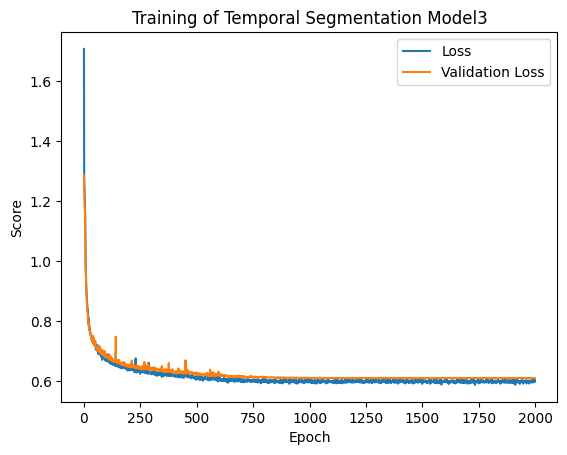

In [67]:
plt.figure()
plt.plot(model_hist3.history['loss'], label='Loss')
plt.plot(model_hist3.history['val_loss'], label='Validation Loss')

plt.title('Training of Temporal Segmentation Model3')
plt.legend(loc = 'upper right')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.savefig('exp4.3_training.png')
plt.show()

### Predict + visualize output

In [5]:
model_name3="fatepredict_temporal_model3"
model3 = sdw.load_stardist_model(model_name=model_name3)

2023-12-06 18:49:18.842375: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 18:49:18.883382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 18:49:18.886440: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Load pretrained stardist model 'fatepredict_temporal_model3' from folder 'stardist_models'


In [68]:
Y_val_pred3_all = [model3.predict_instances(x, show_tile_progress=False)
              for x in tqdm(X_val)]

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


 17%|█▋        | 1/6 [02:33<12:48, 153.77s/it]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 2/6 [05:14<10:31, 157.94s/it]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3/6 [07:28<07:20, 146.93s/it]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 4/6 [09:43<04:44, 142.43s/it]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 5/6 [12:21<02:28, 148.04s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 6/6 [15:25<00:00, 154.29s/it]


In [71]:
pickle.dump(Y_val_pred3_all, open('exp4.3_Y_val_pred3_all.pkl', 'wb'))

In [72]:
Y_val_pred3_all = pickle.load(open('exp4.3_Y_val_pred3_all.pkl', 'rb'))
Y_val_pred3 = [x[0][0] for x in Y_val_pred3_all]

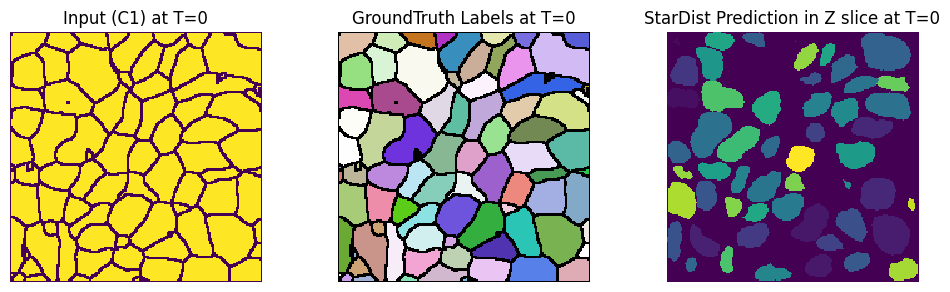

In [78]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(X_val[4][0])
plt.axis('off')
plt.title('Input (C1) at T=0')

fig.add_subplot(rows, columns, 2)
plt.imshow(Y_val[4][0], cmap=lbl_cmap)
plt.axis('off')
plt.title('GroundTruth Labels at T=0')

fig.add_subplot(rows, columns, 3)
plt.imshow(Y_val_pred3[4][0])
plt.axis('off')
plt.title('StarDist Prediction in Z slice at T=0')

plt.tight_layout()
plt.savefig('4.3_model3_predicted_track.png')
plt.show()

In [74]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats3 = [matching_dataset(Y_val, Y_val_pred3, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


### Measure performance

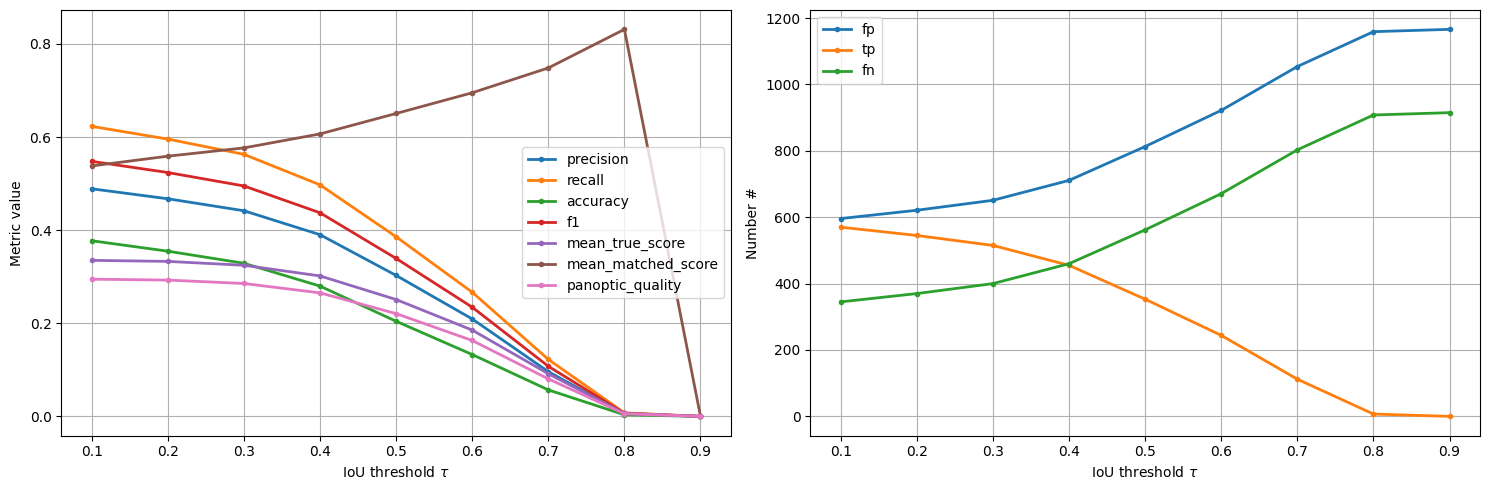

In [79]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats3], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats3], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.savefig('4.3_pr_stardist_2d_track.png')

In [27]:
print('%.3f & %.3f & %.3f & %.3f & %.2f & %.2f\\\\' % (stats3[taus.index(0.5)].f1, stats3[taus.index(0.5)].accuracy, stats3[taus.index(0.7)].f1, stats3[taus.index(0.7)].accuracy, stats3[taus.index(0.9)].f1, stats3[taus.index(0.9)].accuracy))

0.351 & 0.213 & 0.069 & 0.036 & 0.00 & 0.00\\


In [75]:
print('%.3f & %.3f & %.3f & %.3f & %.2f & %.2f\\\\' % (stats3[taus.index(0.5)].f1, stats3[taus.index(0.5)].accuracy, stats3[taus.index(0.7)].f1, stats3[taus.index(0.7)].accuracy, stats3[taus.index(0.9)].f1, stats3[taus.index(0.9)].accuracy))

0.339 & 0.204 & 0.108 & 0.057 & 0.00 & 0.00\\


#### HOTA

0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
{'HOTA': array([0.57560198, 0.57359695, 0.56008527, 0.55127599, 0.54519343,
       0.53226609, 0.52354629, 0.50229117, 0.47608572, 0.45315127,
       0.43158333, 0.39448076, 0.35881463, 0.3247049 , 0.2843554 ,
       0.22616856, 0.1364194 , 0.0388175 , 0.        ]), 'DetA': array([0.57402812, 0.56883759, 0.55600981, 0.54589764, 0.53964401,
       0.52483974, 0.51392204, 0.49254902, 0.46384615, 0.43622642,
       0.41067457, 0.36808052, 0.32983927, 0.28842248, 0.23893229,
       0.18419415, 0.09367816, 0.01547492, 0.        ]), 'AssA': array([0.57718015, 0.57839613, 0.5641906 , 0.55670732, 0.55079991,
       0.53979752, 0.53335078, 0.51222601, 0.48864826, 0.47073278,
       0.45355662, 0.42277454, 0.39033539, 0.3655515 , 0.33841385,
       0.27770816, 0.19866159, 0.09737036, 0.        ]), 'DetRe': array([0.77890011, 0.77441077, 0.76318743, 0.75420875, 0.74859708,
       0.73512907, 0.72502806, 0.70482604, 0.67676768, 0.64870932,
       0.621

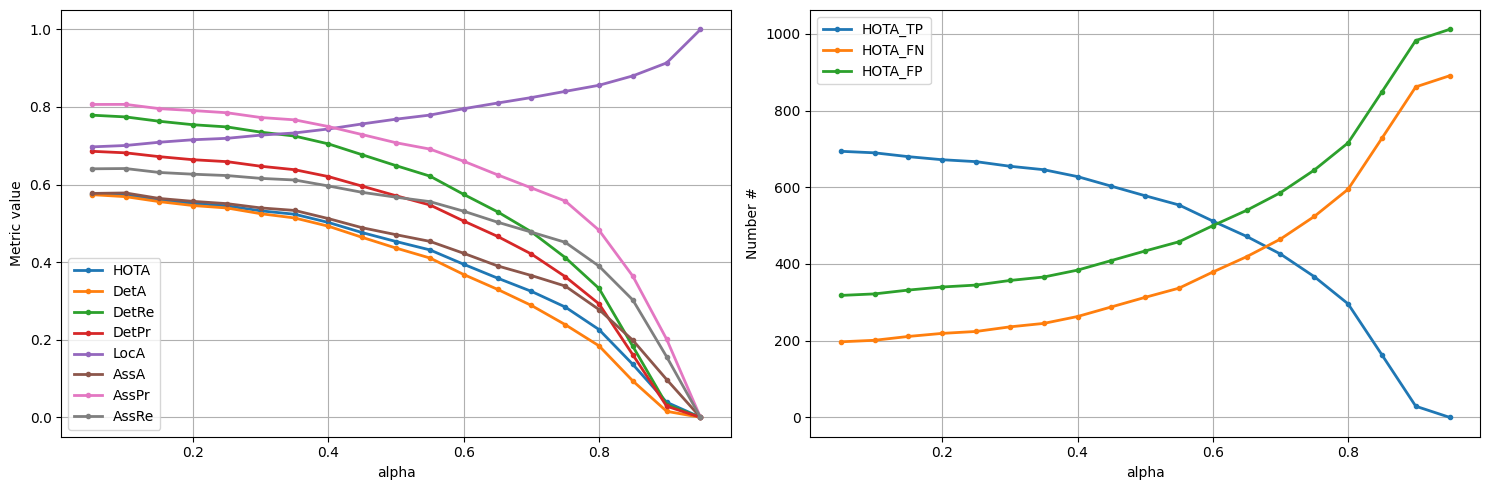

In [76]:
from trackeval.metrics.hota import HOTA
from trackeval_fatepredict import FatePredictDataset

track_eval3 = FatePredictDataset(Y_val[0], Y_val_pred3[0])
hota3 = HOTA()
hota_metrics3 = hota3.eval_sequence(track_eval3.data)

# Print metrics
print(hota_metrics3)

# Visualize
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('HOTA', 'DetA', 'DetRe', 'DetPr', 'LocA', 'AssA', 'AssPr', 'AssRe'):
    ax1.plot(hota3.array_labels, [s for s in hota_metrics3[m]], '.-', lw=2, label=m)
ax1.set_xlabel(r'alpha')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('HOTA_TP', 'HOTA_FN', 'HOTA_FP'):
    ax2.plot(hota3.array_labels, [s for s in hota_metrics3[m]], '.-', lw=2, label=m)
ax2.set_xlabel(r'alpha')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.savefig('4.3_hota_metrics_stardist_2d_track.png')

In [77]:
print('%.3f & %.3f & %.3f & %.3f & %.3f & %.3f & %.3f & %.3f\\\\' % (hota_metrics3['AssA'][9], hota_metrics3['AssA'][17], hota_metrics3['DetA'][9], hota_metrics3['DetA'][17],hota_metrics3['LocA'][9], hota_metrics3['LocA'][17], hota_metrics3['HOTA'][9], hota_metrics3['HOTA'][17]))

0.471 & 0.097 & 0.436 & 0.015 & 0.769 & 0.914 & 0.453 & 0.039\\
